In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor  # scikit-learn sarmalı

# RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Machine Learning - Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Machine Learning - Optuna
import optuna
from optuna.samplers import TPESampler


# 📄 Sigorta Talep Veriseti Özellik Tanımları

## 🗓️ Tarih & Zaman Özellikleri
- **Month**: Sigorta talebinin yapıldığı ay.
- **WeekOfMonth**: Sigorta talebinin yapıldığı ayın haftası.
- **DayOfWeek**: Sigorta talebinin yapıldığı haftanın günü.
- **DayOfWeekClaimed**: Sigorta talebinin işlendiği haftanın günü.
- **MonthClaimed**: Sigorta talebinin işlendiği ay.
- **WeekOfMonthClaimed**: Sigorta talebinin işlendiği ayın haftası.
- **Year**: Talebin yapıldığı veya işlendiği yıl.

## 🚗 Araç & Poliçe Bilgileri
- **Make**: Talebe konu olan aracın üreticisi.
- **VehicleCategory**: Aracın kategorisi (örn. sedan, SUV).
- **VehiclePrice**: Aracın fiyatı.
- **AgeOfVehicle**: Talebe konu olan aracın yaşı.
- **PolicyNumber**: Sigorta poliçesinin benzersiz numarası.
- **PolicyType**: Sigorta poliçesi türü (örn. kapsamlı, üçüncü şahıs).
- **BasePolicy**: Ana poliçe türü (örn. Sorumluluk, Çarpışma, Tüm Riskler).
- **Days_Policy_Accident**: Poliçe başlangıcından kazaya kadar geçen gün sayısı.
- **Days_Policy_Claim**: Poliçe başlangıcından talep yapılana kadar geçen gün sayısı.
- **Deductible**: Sigortalının kendi cebinden ödemesi gereken miktar.
- **NumberOfCars**: Poliçe kapsamında sigortalanmış araç sayısı (aralıklarla kategorize edilmiş).

## 👤 Sigortalı Demografik Bilgileri
- **Sex**: Sigortalının cinsiyeti.
- **MaritalStatus**: Sigortalının medeni durumu.
- **Age**: Sigortalının yaşı.
- **AgeOfPolicyHolder**: Poliçe sahibinin yaşı.

## 📍 Kaza & Talep Durumu Bilgileri
- **AccidentArea**: Kazanın gerçekleştiği bölge (örn. kentsel, kırsal).
- **Fault**: Kazada sigortalının kusurlu olup olmadığını belirtir.
- **PoliceReportFiled**: Kaza için polis raporu tutulup tutulmadığını belirtir.
- **WitnessPresent**: Olay yerinde tanık olup olmadığını belirtir.
- **FraudFound_P**: Talepte dolandırıcılık tespit edilip edilmediğini belirtir.
- **RepNumber**: Talebi yöneten sigorta temsilcisinin numarası.
- **AgentType**: Poliçeyi yöneten sigorta temsilcisi türü (örn. dahili, harici).
- **DriverRating**: Sürücünün puanı, genellikle sürüş geçmişi gibi faktörlere göre belirlenir.

## 📂 Talep Geçmişi & Ek Belgeler
- **PastNumberOfClaims**: Sigortalının daha önce yaptığı talep sayısı.
- **NumberOfSuppliments**: Ana taleple ilişkili ek belge veya ek taleplerin sayısı (aralıklarla kategorize edilmiş).
- **AddressChange_Claim**: Talep sırasında sigortalının adres değişikliği yapıp yapmadığını belirtir (aralıklarla kategorize edilmiş).


In [ ]:
#load data
data = pd.read_csv("insurance.csv")

In [ ]:
# Set options to Show all collumns
pd.set_option('display.max_columns', None)
data

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,35,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15416,5,400,4,more than 30,more than 30,2 to 4,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,30,Policy Holder,Sedan - Liability,Sport,30000 to 39000,0,15417,11,400,3,more than 30,more than 30,more than 4,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,24,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15418,4,400,4,more than 30,more than 30,more than 4,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,34,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,15419,6,400,4,more than 30,more than 30,none,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


In [ ]:
#check for nulls
data_cleaned = data.copy()
data_cleaned.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [ ]:
#check for dupl
duplicate_rows = data_cleaned[data_cleaned.duplicated()]
duplicate_rows.count()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [ ]:
data_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
WeekOfMonth,15420.0,2.788586,1.287585,1.0,2.00,3.0,4.00,5.0
WeekOfMonthClaimed,15420.0,2.693969,1.259115,1.0,2.00,3.0,4.00,5.0
Age,15420.0,39.855707,13.492377,0.0,31.00,38.0,48.00,80.0
FraudFound_P,15420.0,0.059857,0.237230,0.0,0.00,0.0,0.00,1.0
PolicyNumber,15420.0,7710.500000,4451.514911,1.0,3855.75,7710.5,11565.25,15420.0
RepNumber,15420.0,8.483268,4.599948,1.0,5.00,8.0,12.00,16.0
Deductible,15420.0,407.704280,43.950998,300.0,400.00,400.0,400.00,700.0
DriverRating,15420.0,2.487808,1.119453,1.0,1.00,2.0,3.00,4.0
Year,15420.0,1994.866472,0.803313,1994.0,1994.00,1995.0,1996.00,1996.0


In [ ]:
#FUNCTION: Summarize the characteristic of dataset
def summarize(DataFrame):

    summary = pd.DataFrame()


    summary['Data Type'] = DataFrame.dtypes

    summary['N Unique'] = DataFrame.nunique()

    summary['Unique'] = DataFrame.apply(lambda x: x.unique().tolist())

    summary['Max'] = DataFrame.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else '-')

    summary['Min'] = DataFrame.apply(lambda x: x.min() if pd.api.types.is_numeric_dtype(x) else '-')

    #Measures of Central Tendency: Mean, Median, Mode
    summary['Mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Median'] = DataFrame.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Mode'] = DataFrame.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '-')

    #Measures of Dispersion: Range, Variance, Standard Deviation
    summary['Range'] = DataFrame.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Variance'] = DataFrame.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Standard Deviation'] = DataFrame.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else '-')

    #Measures of Shape: Skewness, Kurtosis
    summary['Skewness'] = DataFrame.apply(lambda x: round(x.skew(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Kurtosis'] = DataFrame.apply(lambda x: round(x.kurt(), 2) if pd.api.types.is_numeric_dtype(x) else '-')

    return summary


| 🏷️ Başlık               | 📌 Açıklama                                                                 |
|-------------------------|------------------------------------------------------------------------------|
| **Data Type**           | Sütunun veri tipi (`int64`, `float64`, `object` vb.)                         |
| **N Unique**            | Sütundaki benzersiz (unique) değer sayısı                                    |
| **Unique**              | Sütundaki tüm benzersiz değerlerin listesi                                   |
| **Max**                 | Sayısal değerler için maksimum (en büyük) değer                              |
| **Min**                 | Sayısal değerler için minimum (en küçük) değer                               |
| **Mean**                | Aritmetik ortalama (sadece sayısal sütunlar için)                            |
| **Median**              | Ortanca değer: verilerin ortasındaki değer                                   |
| **Mode**                | En sık tekrar eden (mod) değer                                               |
| **Range**               | Değer aralığı: `Max - Min`                                                   |
| **Variance**            | Varyans: verilerin ortalamadan ne kadar saptığını gösterir                   |
| **Standard Deviation**  | Standart sapma: varyansın karekökü                                           |
| **Skewness**            | Çarpıklık: dağılımın sağa mı sola mı kayık olduğunu gösterir                 |
| **Kurtosis**            | Basıklık: dağılımın tepe noktasının sivriliği veya yaygınlığını ölçer        |


# VERİYİ ÖZETLEME

In [ ]:
summary = summarize(data_cleaned)
summary

,Data Type,N Unique,Unique,Max,Min,Mean,Median,Mode,Range,Variance,Standard Deviation,Skewness,Kurtosis
Month,object,12,"[Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonth,int64,5,"[5, 3, 2, 4, 1]",5,1,2.79,3.0,3,4,1.657876,1.287585,0.12,-1.1
DayOfWeek,object,7,"[Wednesday, Friday, Saturday, Monday, Tuesday,...",-,-,-,-,Monday,-,-,-,-,-
Make,object,19,"[Honda, Toyota, Ford, Mazda, Chevrolet, Pontia...",-,-,-,-,Pontiac,-,-,-,-,-
AccidentArea,object,2,"[Urban, Rural]",-,-,-,-,Urban,-,-,-,-,-
DayOfWeekClaimed,object,8,"[Tuesday, Monday, Thursday, Friday, Wednesday,...",-,-,-,-,Monday,-,-,-,-,-
MonthClaimed,object,13,"[Jan, Nov, Jul, Feb, Mar, Dec, Apr, Aug, May, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonthClaimed,int64,5,"[1, 4, 2, 3, 5]",5,1,2.69,3.0,2,4,1.585371,1.259115,0.16,-1.09
Sex,object,2,"[Female, Male]",-,-,-,-,Male,-,-,-,-,-
MaritalStatus,object,4,"[Single, Married, Widow, Divorced]",-,-,-,-,Married,-,-,-,-,-


# KATEOGIK VERILERI GORSELLESTIRME

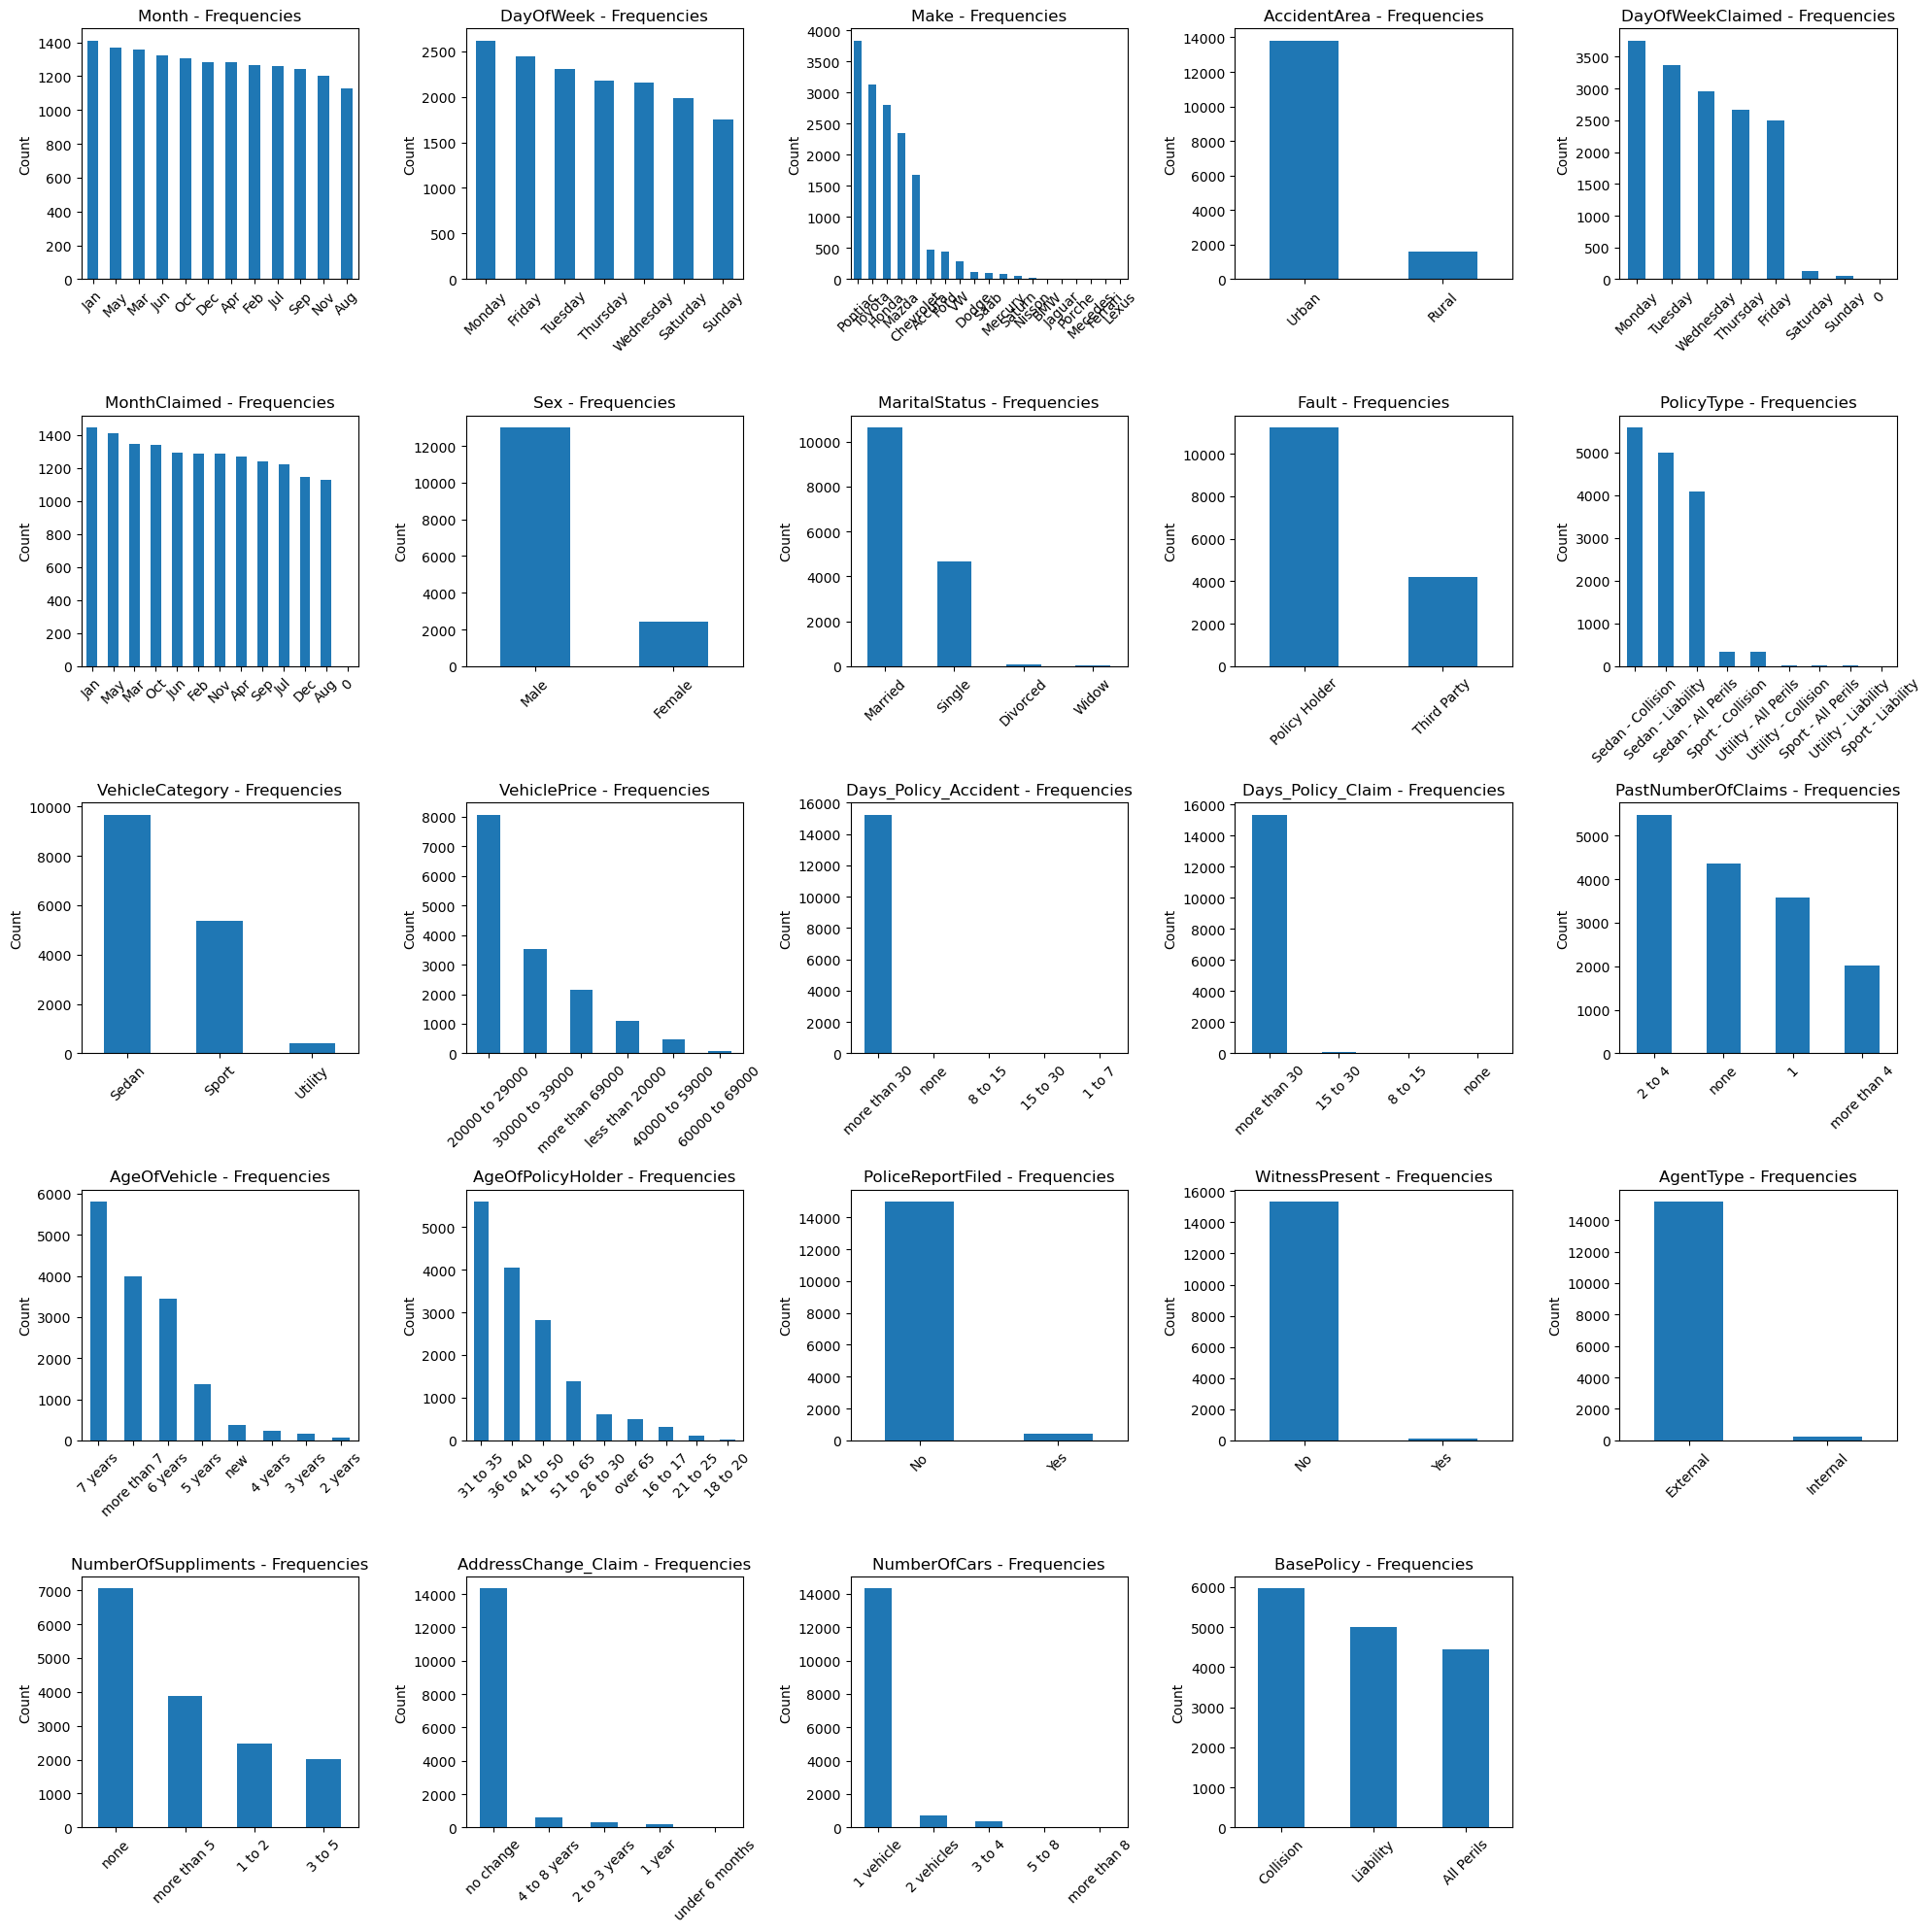

In [ ]:
categorical_features = data_cleaned.select_dtypes(include=['object']).copy()

num_plots = len(categorical_features.columns)
cols = 5
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features.columns):
    categorical_features[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} - Frequencies')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

#Boş kalan eksenleri gizle
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# SAYISAL VERİLERİN DAĞILIMLARI

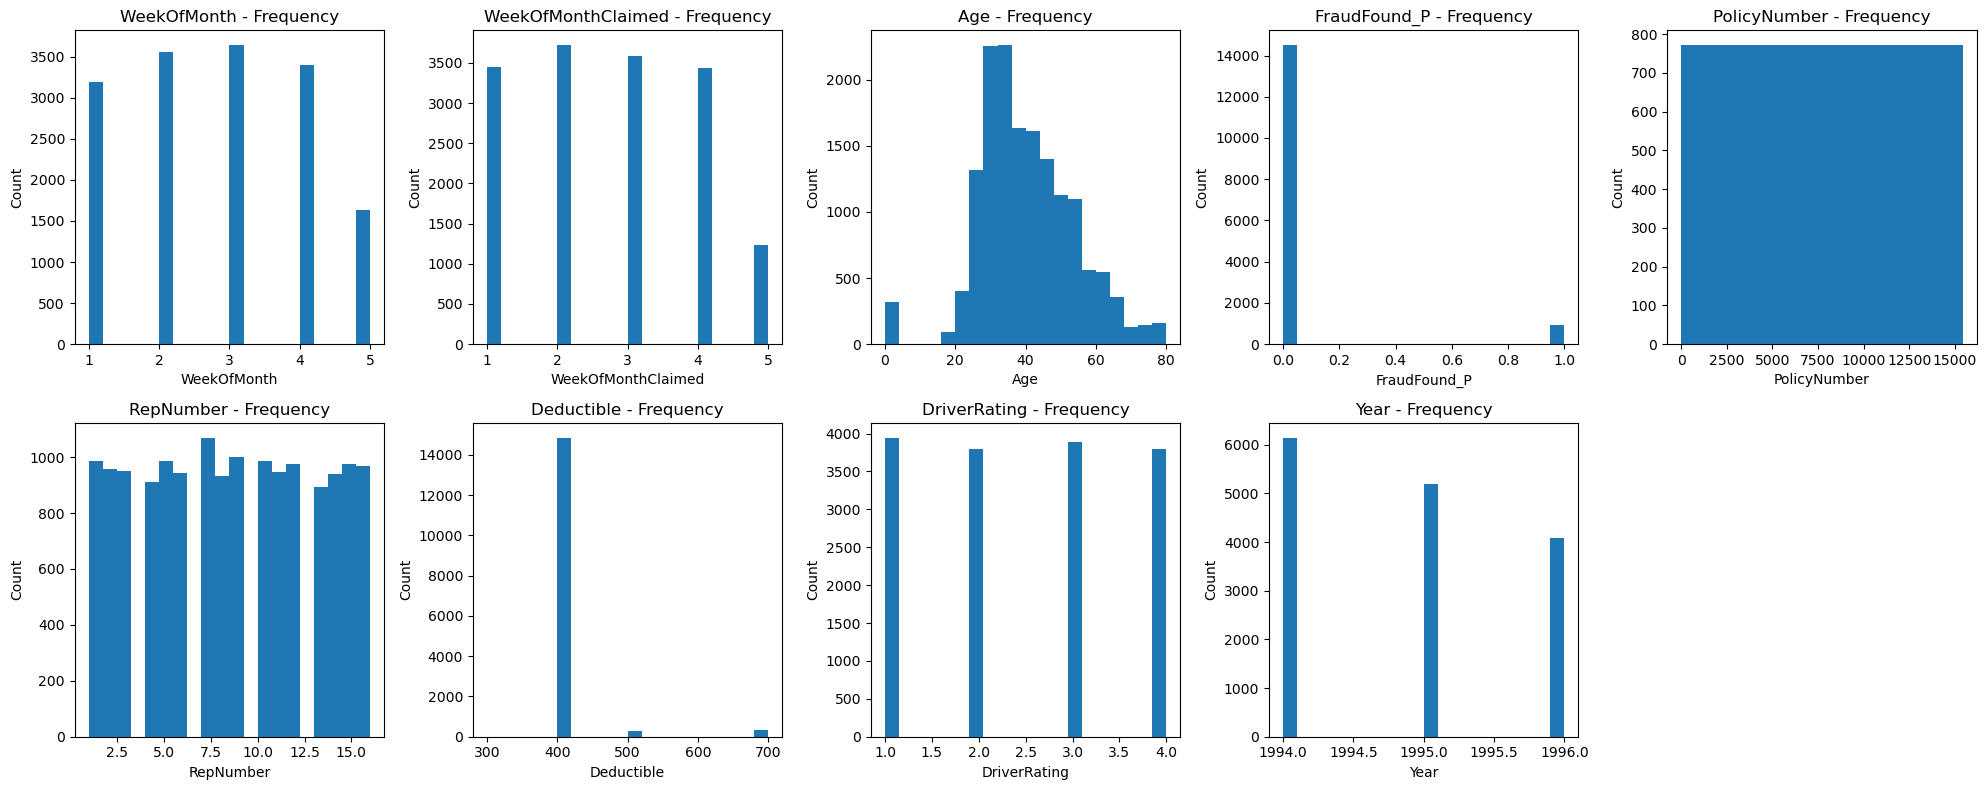

In [ ]:

#Sayısal veri türündeki sütunları seç
numeric_features = data_cleaned.select_dtypes(include=['int64', 'float64'])

num_plots = len(numeric_features.columns)
cols = 5
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_features.columns):
    axes[i].hist(numeric_features[col], bins=20)
    axes[i].set_title(f'{col} - Frequency')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# UÇ DEĞER ANALİZ EDELİM

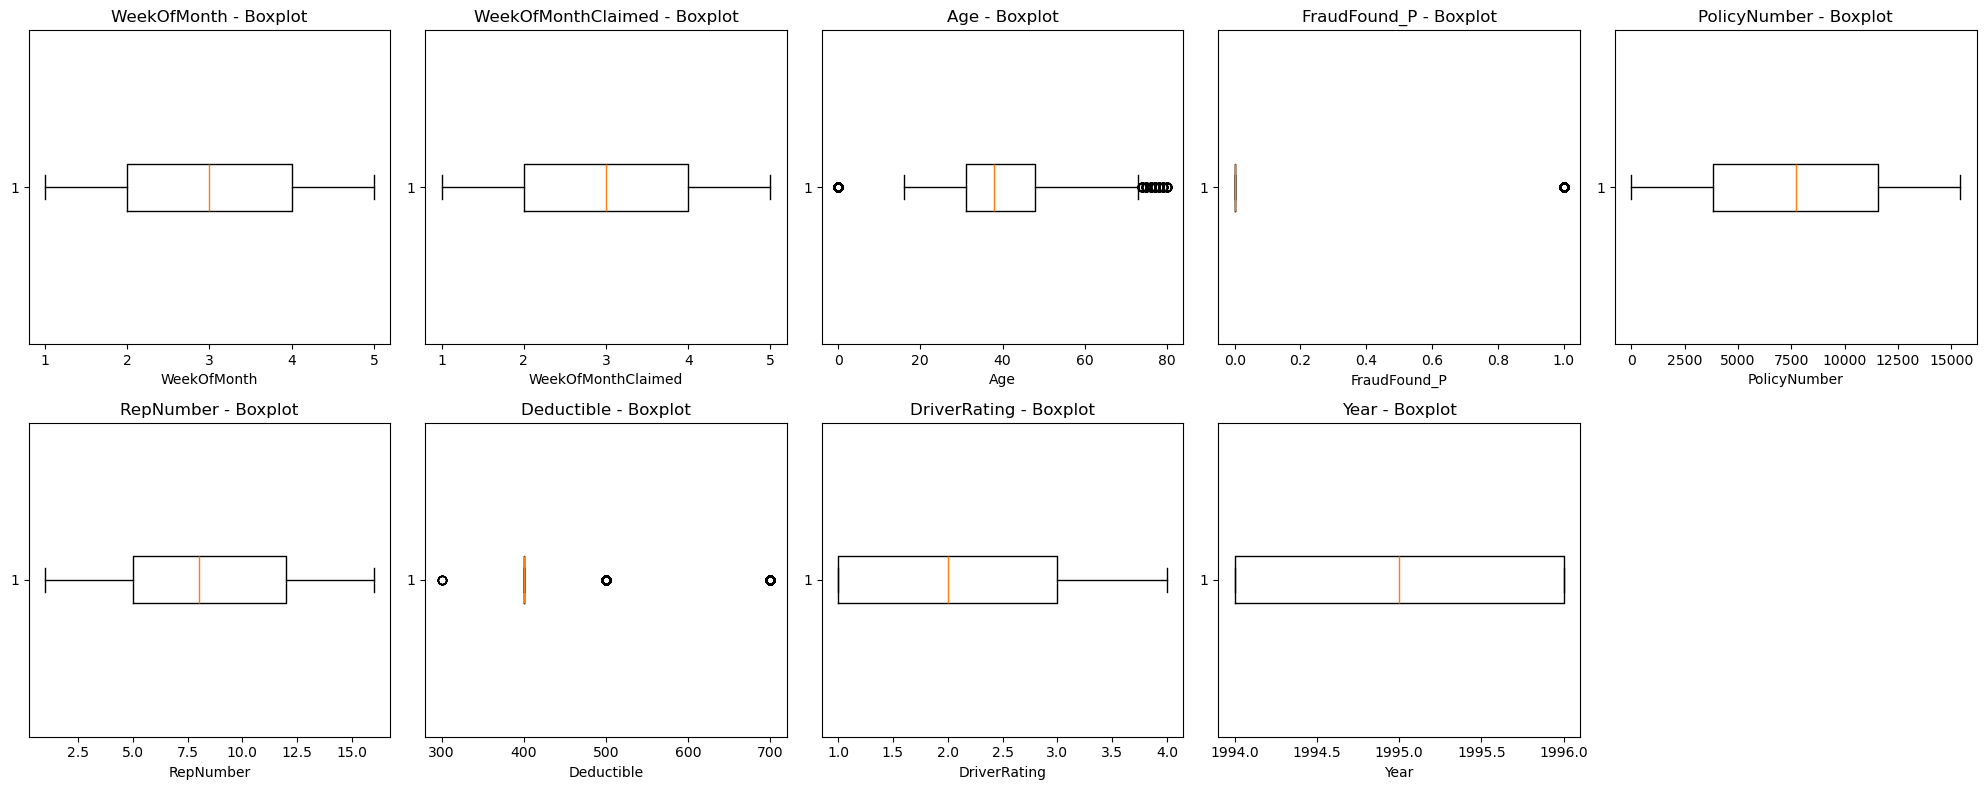

In [ ]:
#Sayısal sütunlar için boxplot çizdirelim
num_plots = len(numeric_features.columns)
cols = 5
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_features.columns):
    axes[i].boxplot(numeric_features[col], vert=False)
    axes[i].set_title(f'{col} - Boxplot')
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


BURADA repnumber driverrating fraudfound gibi değerlerin uç değerleri önemsiz çünkü bunlar aslında kategoriktir. aynı zamanda deductible da sınırlı sayıda değer içerdiği için outlier beklemiyoruz.

# HEDEFİMİZİN DAĞILIMI OLDUKÇA ORANTISIZ OLDUĞUNDAN DOLAYI ileride OVERSAMPLİNG YAPMALIYIZ

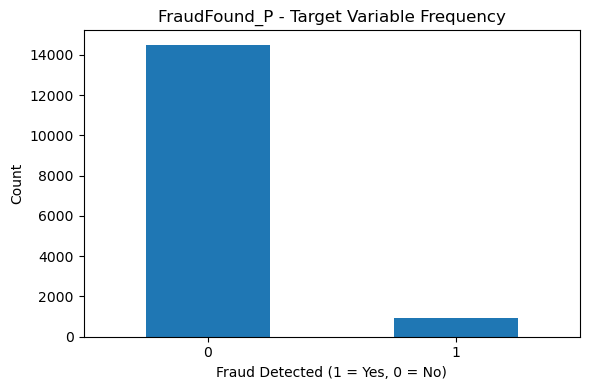

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [ ]:
#Hedef değişkenin (FraudFound_P) frekans dağılımını inceleyelim
fraud_counts = data_cleaned['FraudFound_P'].value_counts()

plt.figure(figsize=(6, 4))
fraud_counts.plot(kind='bar')
plt.title('FraudFound_P - Target Variable Frequency')
plt.xlabel('Fraud Detected (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Sayısal değerleri de görelim
fraud_counts

# DATA PREPROCCESSING

In [ ]:
#drop policy number because its an id
data_cleaned = data_cleaned.drop('PolicyNumber' ,axis = 1)
#gereksiz satırları kaldıralım
data_cleaned = data.drop(columns=['WeekOfMonth', 'DayOfWeekClaimed', 'WeekOfMonthClaimed' , 'DayOfWeek'])


## BİNARY OLAN KATEGORİK VERİLERİ ÇEVİRELİM

In [ ]:
#Binary sütunları otomatik bul (FraudFound_P hariç) ve label encoding uygula
binary_columns = [col for col in data_cleaned.columns if data_cleaned[col].nunique() == 2 and col != 'FraudFound_P']

#Label Encoding uygula
for col in binary_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])

data_cleaned[binary_columns].head()


,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,AgentType
0,1,0,0,0,0,0
1,1,1,0,1,0,0
2,1,1,0,0,0,0
3,0,1,1,1,0,0
4,1,0,1,0,0,0


<iframe src="https://www.kaggle.com/embed/hobeomlee/fraud-detection-modeling-guidebook-a-to-z?cellIds=60&kernelSessionId=185131359" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="🚗Fraud Detection Modeling Guidebook: A to Z🕵️‍♂"></iframe>

<iframe src="https://www.kaggle.com/embed/hobeomlee/fraud-detection-modeling-guidebook-a-to-z?cellIds=60&kernelSessionId=185131359" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="🚗Fraud Detection Modeling Guidebook: A to Z🕵️‍♂"></iframe>

## 02) Data Transformation - Encoding Categorical Variables  
### 🎯 Ordinal & Nominal Categorical Variables (Label Encoding)

---

### 🧩 **Ordinal Categorical Variables**
Ordinal kategorik değişkenler, kategoriler arasında **mantıksal bir sıralama** veya **derecelendirme** bulunan değişkenlerdir.  
**Örnek Değişkenler:**
- `VehiclePrice`
- `DriverRating`
- `AgeOfVehicle`
- `BasePolicy`

#### 🛠️ Ordinal Label Encoding Yaparken Dikkat Edilmesi Gerekenler:
- **✅ Sıralamayı Koru:** Encoding, kategorilerin doğal sırasını yansıtmalıdır.
- **📊 Özel Eşleme Kullan:** Sıralamaya uygun bir sözlük (dictionary) ile kategorileri sayılara eşleştir.
- **📈 Model Yorumlaması:** Modelin bu sayısal değerlerin bir sıralamayı temsil ettiğini anlaması önemlidir.
- **🔁 Tutarlılık:** Eğitim ve test veri setlerinde aynı eşlemeyi kullan.

---

### 🧩 **Nominal Categorical Variables**
Nominal kategorik değişkenler, kategoriler arasında **herhangi bir sıralama bulunmayan** değişkenlerdir.  
**Örnekler:** `Red`, `Blue`, `Green`

#### ❗ Not:
- İNTEGER HALİNDE OLUPTA SIRALI OLMAYAN VERİLERDE VARDIR. BU VERİLER ENCODİNG İLE ÇEVİRİLMELİDİR
- Bu tür değişkenler için **Label Encoding genellikle uygun değildir**, çünkü model bu değerler arasında **sıralama olduğunu varsayabilir**.
- **One-Hot Encoding** genellikle daha doğrudur.

---


ordinal verilerimiz = VehiclePrice  Days_Policy_Accident	Days_Policy_Claim PastNumberOfClaims  AgeOfVehicle  AgeOfPolicyHolder	 NumberOfSuppliments	 AddressChange_Claim NumberOfCars

In [ ]:
#Ordinal veriler
ordinal_columns = [
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim',
    'NumberOfCars'
]

#İlgili sütunlar için benzersiz (unique) değerleri yazdıralım
unique_values = {
    'AgeOfVehicle': data_cleaned['AgeOfVehicle'].unique(),
    'AgeOfPolicyHolder': data_cleaned['AgeOfPolicyHolder'].unique(),
    'NumberOfSuppliments': data_cleaned['NumberOfSuppliments'].unique(),
    'AddressChange_Claim': data_cleaned['AddressChange_Claim'].unique(),
    'NumberOfCars': data_cleaned['NumberOfCars'].unique()
}

unique_values



{'AgeOfVehicle': array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
        '4 years', '2 years'], dtype=object),
 'AgeOfPolicyHolder': array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
        '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object),
 'NumberOfSuppliments': array(['none', 'more than 5', '3 to 5', '1 to 2'], dtype=object),
 'AddressChange_Claim': array(['1 year', 'no change', '4 to 8 years', '2 to 3 years',
        'under 6 months'], dtype=object),
 'NumberOfCars': array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
       dtype=object)}

In [ ]:
#Ordinal veriler için manuel etiket eşlemeleri
age_of_vehicle_mapping = {
    "new": 0,
    "2 years": 1,
    "3 years": 2,
    "4 years": 3,
    "5 years": 4,
    "6 years": 5,
    "7 years": 6,
    "more than 7": 7
}

age_of_policyholder_mapping = {
    "16 to 17": 0,
    "18 to 20": 1,
    "21 to 25": 2,
    "26 to 30": 3,
    "31 to 35": 4,
    "36 to 40": 5,
    "41 to 50": 6,
    "51 to 65": 7,
    "over 65": 8
}

number_of_suppliments_mapping = {
    "none": 0,
    "1 to 2": 1,
    "3 to 5": 2,
    "more than 5": 3
}

address_change_claim_mapping = {
    "no change": 0,
    "under 6 months": 1,
    "1 year": 2,
    "2 to 3 years": 3,
    "4 to 8 years": 4
}

number_of_cars_mapping = {
    "1 vehicle": 0,
    "2 vehicles": 1,
    "3 to 4": 2,
    "5 to 8": 3,
    "more than 8": 4
}

data_cleaned['AgeOfVehicle'] = data_cleaned['AgeOfVehicle'].map(age_of_vehicle_mapping)
data_cleaned['AgeOfPolicyHolder'] = data_cleaned['AgeOfPolicyHolder'].map(age_of_policyholder_mapping)
data_cleaned['NumberOfSuppliments'] = data_cleaned['NumberOfSuppliments'].map(number_of_suppliments_mapping)
data_cleaned['AddressChange_Claim'] = data_cleaned['AddressChange_Claim'].map(address_change_claim_mapping)
data_cleaned['NumberOfCars'] = data_cleaned['NumberOfCars'].map(number_of_cars_mapping)

data_cleaned[ordinal_columns].head()


,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,AddressChange_Claim,NumberOfCars
0,2,3,0,2,2
1,5,4,0,0,0
2,6,6,0,0,0
3,7,7,3,0,0
4,4,4,0,0,0


In [ ]:
data_cleaned.dtypes

Month                   object
Make                    object
AccidentArea             int32
MonthClaimed            object
Sex                      int32
MaritalStatus           object
Age                      int64
Fault                    int32
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle             int64
AgeOfPolicyHolder        int64
PoliceReportFiled        int32
WitnessPresent           int32
AgentType                int32
NumberOfSuppliments      int64
AddressChange_Claim      int64
NumberOfCars             int64
Year                     int64
BasePolicy              object
dtype: object

# ONE HOT ENCODING
one hot encoding için integer değerlerdende kategorik olup ordinal olmayanları almamaız gerekior.

In [ ]:
#ordinal olamyan verilerimizi gösterelim
summary = summarize(data_cleaned.drop(columns=ordinal_columns))
summary

,Data Type,N Unique,Unique,Max,Min,Mean,Median,Mode,Range,Variance,Standard Deviation,Skewness,Kurtosis
Month,object,12,"[Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, ...",-,-,-,-,Jan,-,-,-,-,-
Make,object,19,"[Honda, Toyota, Ford, Mazda, Chevrolet, Pontia...",-,-,-,-,Pontiac,-,-,-,-,-
AccidentArea,int32,2,"[1, 0]",1,0,0.9,1.0,1,1,0.092898,0.304792,-2.6,4.77
MonthClaimed,object,13,"[Jan, Nov, Jul, Feb, Mar, Dec, Apr, Aug, May, ...",-,-,-,-,Jan,-,-,-,-,-
Sex,int32,2,"[0, 1]",1,0,0.84,1.0,1,1,0.132318,0.363755,-1.89,1.56
MaritalStatus,object,4,"[Single, Married, Widow, Divorced]",-,-,-,-,Married,-,-,-,-,-
Age,int64,66,"[21, 34, 47, 65, 27, 20, 36, 0, 30, 42, 71, 52...",80,0,39.86,38.0,30,80,182.044228,13.492377,0.15,0.8
Fault,int32,2,"[0, 1]",1,0,0.27,0.0,0,1,0.197903,0.444863,1.03,-0.95
PolicyType,object,9,"[Sport - Liability, Sport - Collision, Sedan -...",-,-,-,-,Sedan - Collision,-,-,-,-,-
VehicleCategory,object,3,"[Sport, Utility, Sedan]",-,-,-,-,Sedan,-,-,-,-,-


In [ ]:
#RepNumber stünu integer olduğu için one hotta çalışmaz.
dtype_change_string = ['RepNumber', 'Deductible']
data_cleaned[dtype_change_string] = data_cleaned[dtype_change_string].astype(str)
columns_to_encode = [
    'Month', 'Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType',
    'VehicleCategory', 'VehiclePrice', 'RepNumber', 'Deductible',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'BasePolicy'
]

#Apply one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=columns_to_encode)


In [ ]:
data_encoded.head()


,AccidentArea,Sex,Age,Fault,FraudFound_P,PolicyNumber,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ferrari,Make_Ford,Make_Honda,Make_Jaguar,Make_Lexus,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Porche,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,MonthClaimed_0,MonthClaimed_Apr,MonthClaimed_Aug,MonthClaimed_Dec,MonthClaimed_Feb,MonthClaimed_Jan,MonthClaimed_Jul,MonthClaimed_Jun,MonthClaimed_Mar,MonthClaimed_May,MonthClaimed_Nov,MonthClaimed_Oct,MonthClaimed_Sep,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,VehiclePrice_20000 to 29000,VehiclePrice_30000 to 39000,VehiclePrice_40000 to 59000,VehiclePrice_60000 to 69000,VehiclePrice_less than 20000,VehiclePrice_more than 69000,RepNumber_1,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,RepNumber_14,RepNumber_15,RepNumber_16,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,Deductible_300,Deductible_400,Deductible_500,Deductible_700,Days_Policy_Accident_1 to 7,Days_Policy_Accident_15 to 30,Days_Policy_Accident_8 to 15,Days_Policy_Accident_more than 30,Days_Policy_Accident_none,Days_Policy_Claim_15 to 30,Days_Policy_Claim_8 to 15,Days_Policy_Claim_more than 30,Days_Policy_Claim_none,PastNumberOfClaims_1,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,1,0,21,0,0,1,1,2,3,0,0,0,0,2,2,1994,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True
1,1,1,34,0,0,2,4,5,4,1,0,0,0,0,0,1994,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False
2,1,1,47,0,0,3,3,6,6,0,0,0,0,0,0,1994,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False
3,0,1,65,1,0,4,2,7,7,1,0,0,3,0,0,1994,False,False,False,Fa

Şimdi one hot encoder ile encode olmuş stünlarımızda şunu yapacağız . bir stünumuzdaki true veya false değerinin toplamı 5i geçmiyorsa o stünü sileceğiz çünkü tüm stünu aynı kabul edersek bu stünun modele sokulmasının bir anlamı olmaz. hatta 5 çok düşük bir sayı daha fazla da yapılabilir.

In [ ]:
onehot_encoded_columns = [col for col in data_encoded.columns if '_' in col] #  _ işareti olanlar one hot encoding yapılmış olanlar Fraud hariç onu kaldırıyoz
onehot_encoded_columns.remove("FraudFound_P")
print("The Number of One-hot Encoded Columns: ", len(onehot_encoded_columns))

The Number of One-hot Encoded Columns:  103


In [ ]:
constant_features = []
for col in onehot_encoded_columns:
    if data_encoded[col].sum() <= 5:
        constant_features.append(col)
print("The Number of Constant Features: ", len(constant_features))
data_encoded.shape

The Number of Constant Features:  7


(15420, 118)

In [ ]:
data_encoded.drop(columns=constant_features, axis=1, inplace=True)
data_encoded.shape

(15420, 111)

# Data Cleaning - Correcting Inaccurate Data & Handling Outliers (Age)

In [ ]:
#IQR sınırlarını yeniden hesapla
Q1  = data_encoded['Age'].quantile(0.25)
Q3  = data_encoded['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Uç değerleri (outliers) hariç tutarak yeni bir DataFrame oluştur
data_encoded = data_encoded[
    (data_encoded['Age'] >= lower_bound) &
    (data_encoded['Age'] <= upper_bound)
].reset_index(drop=True)

data_encoded.shape

(14873, 111)

# 04. SMOTE Oversampling — *Synthetic Minority Oversampling Technique* ⚙️
Şimdi dengesiz olan targetimizi dengeleyeceğiz.


In [ ]:
# --- 1. Feature-target ayrımı --------------------------------------------
X = data_encoded.drop('FraudFound_P', axis=1)
y = data_encoded['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("Before SMOTE: ", X_train.shape, y_train.shape)
print("After Smote: ", X_train_over.shape, y_train_over.shape)
print()
print("After SMOTE Label Distribution: ", pd.Series(y_train_over).value_counts())

Before SMOTE:  (11898, 110) (11898,)
After Smote:  (22392, 110) (22392,)

After SMOTE Label Distribution:  FraudFound_P
0    11196
1    11196
Name: count, dtype: int64


In [ ]:
#yeni veri setimiz
df_smote = pd.concat([X_train_over, y_train_over], axis=1)
df_smote

,AccidentArea,Sex,Age,Fault,PolicyNumber,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ford,Make_Honda,Make_Jaguar,Make_Mazda,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,MonthClaimed_Apr,MonthClaimed_Aug,MonthClaimed_Dec,MonthClaimed_Feb,MonthClaimed_Jan,MonthClaimed_Jul,MonthClaimed_Jun,MonthClaimed_Mar,MonthClaimed_May,MonthClaimed_Nov,MonthClaimed_Oct,MonthClaimed_Sep,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,VehiclePrice_20000 to 29000,VehiclePrice_30000 to 39000,VehiclePrice_40000 to 59000,VehiclePrice_60000 to 69000,VehiclePrice_less than 20000,VehiclePrice_more than 69000,RepNumber_1,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,RepNumber_14,RepNumber_15,RepNumber_16,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,Deductible_300,Deductible_400,Deductible_500,Deductible_700,Days_Policy_Accident_1 to 7,Days_Policy_Accident_15 to 30,Days_Policy_Accident_8 to 15,Days_Policy_Accident_more than 30,Days_Policy_Accident_none,Days_Policy_Claim_15 to 30,Days_Policy_Claim_8 to 15,Days_Policy_Claim_more than 30,PastNumberOfClaims_1,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,FraudFound_P
0,1,1,43,0,10029,4,6,5,0,0,0,3,0,0,1995,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True,0
1,1,1,58,0,514,4,7,7,0,0,0,2,0,0,1994,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,0
2,1,1,49,0,10221,1,6,6,0,0,0,0,0,0,1995,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,0
3,1,0,55,1,6725,1,7,6,0,0,0,3,0,2,1995,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,Fal

### Veri Setimizdeki featurlerin önem sıralarını hesaplayalım.

In [ ]:
# --- 1. Feature-target ayrımı --------------------------------------------
X = df_smote.drop('FraudFound_P', axis=1)
y = df_smote['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(
    n_estimators=1,
    random_state=43,
    n_jobs=-1,
)

rf.fit(X_train_over, y_train_over)


RandomForestClassifier(n_estimators=1, n_jobs=-1, random_state=43)

In [ ]:
# --- 3. Test performansı -------------------------------------------------
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2284
           1       0.97      0.98      0.98      2195

    accuracy                           0.98      4479
   macro avg       0.98      0.98      0.98      4479
weighted avg       0.98      0.98      0.98      4479

[[2228   56]
 [  42 2153]]


In [ ]:
# --- 4. Özellik Önemleri -------------------------------------------------
feat_imp = pd.Series(rf.feature_importances_, index=X_train_over.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print("\nEn Önemli 20 Özellik:")
feat_imp_sorted.head(20)


En Önemli 20 Özellik:


BasePolicy_Liability              0.245848
Fault                             0.144061
BasePolicy_Collision              0.053143
VehiclePrice_20000 to 29000       0.037000
PastNumberOfClaims_none           0.034558
AgeOfVehicle                      0.031357
PolicyNumber                      0.023322
NumberOfSuppliments               0.022315
PastNumberOfClaims_2 to 4         0.021987
PolicyType_Sedan - All Perils     0.018195
VehiclePrice_30000 to 39000       0.017484
PastNumberOfClaims_1              0.016977
PastNumberOfClaims_more than 4    0.014528
Age                               0.013872
VehiclePrice_more than 69000      0.012657
MaritalStatus_Single              0.012170
AgeOfPolicyHolder                 0.011439
Make_Pontiac                      0.011398
Deductible_400                    0.011363
BasePolicy_All Perils             0.011096
dtype: float64

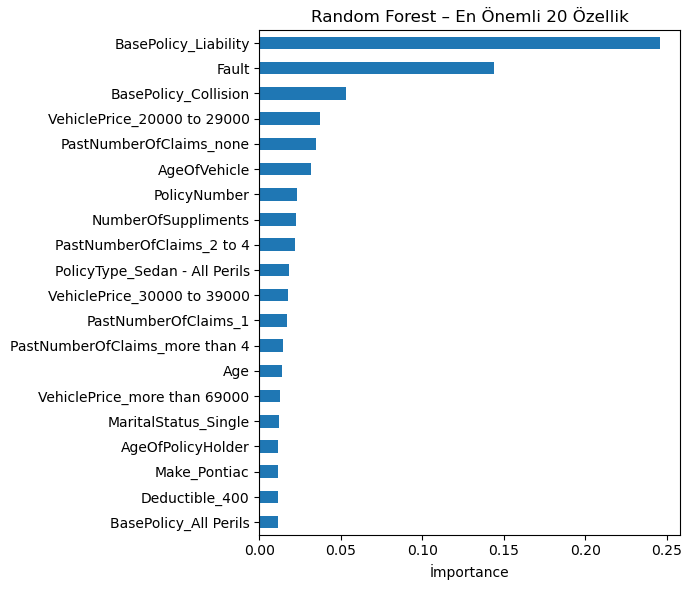

In [ ]:
#Görselleştirme
plt.figure(figsize=(7, 6))
feat_imp_sorted.head(20).sort_values().plot.barh()
plt.title('Random Forest – En Önemli 20 Özellik')
plt.xlabel('İmportance')
plt.tight_layout()
plt.show()

# ✅**05. RFECV Feature Selection - Recursive Feature Elimination Cross Validation (+ VarianceThreshold Method)**✅

#### **What is Recursive Feature Elimination Cross Validation (RFECV)?**
**Recursive Feature Elimination Cross Validation (RFECV)** is a feature selection method that recursively removes less important features based on a specified estimator's performance. It combines the process of Recursive Feature Elimination (RFE) with Cross-Validation (CV) to determine the optimal number of features that yield the best model performance.

* **Reference**: Feature Selection Explained: RFECV by **AVANISHMEED** (Link: https://www.kaggle.com/code/avanishmeed/feature-selection-explained-rfecv)

In [ ]:
X_smote = df_smote.drop(columns="FraudFound_P")
y_smote = df_smote["FraudFound_P"]
print(X_smote.shape, y_smote.shape)

(22392, 110) (22392,)


#### Before moving forward to the RFECV, I performed Pre-feature-selection using **VarianceThreshold**
**VarianceThreshold** is a feature selection method that removes features with low variance. Features with variance below a specified threshold are considered to have little informational value because they exhibit little variability across samples.
* **Reduce noise** Eliminates features that do not vary much, wichi are less likely to be informative.
* **Simplifies the model**: Reduces the number of features, making the model simpler and faster. (This is the reason I performed this before RFECV!)
* **Prevents overfitting**: Helps in reducing the risk of overfitting by removing uninformative features.

Aşırı sayıda one-hot oluşturulmuş veri setlerinde,

Modelin öğrenmeyeceği sabit / neredeyse sabit sütunları temizleyerek

Eğitim süresini ve bellek kullanımını düşürmek için kullanılır.

In [ ]:
# VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # The larger the threshold, the more features are eliminated.
X_reduced = selector.fit_transform(X_smote)
X_reduced.shape

(22392, 87)

In [ ]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_smote.columns[selected_feature_indices]
X_reduced = pd.DataFrame(X_reduced, columns=selected_feature_names)

#### **Now, let's play with RFECV!**

#### You can use any classifier to perform RFECV. I chose **LightGBM** because my dataset contains many categorical variables.
* **CatBoost algorithm** is better in hanlding categorical variables than LightGBM, but the **CatBoost algorithm** costs computing resource too much.

In [ ]:
# LigthGBM
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

#### I used **ROC_AUC** as a scoring parameter because, in fraud detection, it is important to consider both accuracy and recall. For more details about scoring metrics, please click the following link: https://www.v7labs.com/blog/f1-score-guide

In [ ]:
rfecv = RFECV(
    estimator = lightgbm_model,      # ⬅️  Özellikler üzerinde geri­ye doğru
                                     #     eleme yapacak taban model.
                                     #     (LightGBM sınıflandırıcı → ağaç tabanlı)

    step = 1,                        # ⬅️  Her iterasyonda **1** özelliği çıkar.
                                     #     Daha büyük sayı → daha az iterasyon,
                                     #     ama hassasiyeti düşürür.

    cv = StratifiedKFold(5),         # ⬅️  5 katlı, sınıf oranlarını koruyan
                                     #     çapraz doğrulama bölmesi.
                                     #     (Fraud / non-fraud dengesini bozmamak için)

    scoring = 'roc_auc',             # ⬅️  Özellik alt kümelerinin başarısı
                                     #     ROC-AUC metriği ile ölçülür.

    n_jobs = -1                      # ⬅️  Tüm kullanılabilir işlemci çekirdeklerini
                                     #     paralel hesaplama için kullan.
)
rfecv.fit(X_reduced, y_smote)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=42, verbose=-1), n_jobs=-1,
      scoring='roc_auc')

In [ ]:
#rfecv.fit(...) çalıştırıldıktan sonra

#1)Boolean maske → True = kaldı, False = elendi
mask = rfecv.support_

#2)Kalan ve elenen ad listeleri
kept_features     = X_reduced.columns[mask].tolist()
removed_features  = X_reduced.columns[~mask].tolist()

#3)Özet yazdır
print(f"Seçili (kalan) özellik sayısı : {len(kept_features)}")
print(f"Elendi    (çıkarılan) sayısı  : {len(removed_features)}\n")

print("KALAN ÖZELLİKLER:")
print(kept_features)

print("\nÇIKARILAN ÖZELLİKLER:")
print(removed_features)


Seçili (kalan) özellik sayısı : 82
Elendi    (çıkarılan) sayısı  : 5

KALAN ÖZELLİKLER:
['AccidentArea', 'Sex', 'Age', 'Fault', 'PolicyNumber', 'DriverRating', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'NumberOfSuppliments', 'AddressChange_Claim', 'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Make_Accura', 'Make_Chevrolet', 'Make_Ford', 'Make_Honda', 'Make_Mazda', 'Make_Pontiac', 'Make_Toyota', 'Make_VW', 'MonthClaimed_Apr', 'MonthClaimed_Aug', 'MonthClaimed_Dec', 'MonthClaimed_Feb', 'MonthClaimed_Jan', 'MonthClaimed_Jul', 'MonthClaimed_Jun', 'MonthClaimed_Mar', 'MonthClaimed_May', 'MonthClaimed_Nov', 'MonthClaimed_Oct', 'MonthClaimed_Sep', 'MaritalStatus_Married', 'MaritalStatus_Single', 'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision', 'PolicyType_Sport - Collision', 'PolicyType_Utility - All Perils', 'VehicleCategory_Sedan', 'VehicleCategory_U

In [ ]:
#Selected features
optimal_num_features =rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 82


In [ ]:
X_selected = rfecv.transform(X_reduced)

In [ ]:
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

# 🤖**06. Modeling - Optimization using Optuna**🤖

#### **What is Optuna**?
**Optuna** is an automatic hyperparameter optimization framework designed to enhance the performance of machine learning models. It offers a flexible and efficient approach to finding the best hyperparameters by using techniques like **Bayesian Optimization**. Optuna allows users to define an objective function, which it then optimizes through a series of trials, intelligently searching the hyperparameter space.

#### In summary, **Optuna** is a more advanced and efficient tool for hyperparameter optimization compared to GridSearch, offering flexibility, intelligent sampling, and resource-saving features like pruning.
* **Reference**: https://medium.com/@publiciscommerce/optuna-an-automatic-hyperparameter-optimization-framework-f64638621ff7

#### **Why Optuna is Powerful? (Comparing to GridSearch)**
* **Efficiency**: Unlike GridSearch, which exhaustively searches through all possible combinations of hyperparameters, Optuna uses intelligent algorithms to sample promising hyperparameter configurations, significantly reducing the search time and computational cost.
* **Flexibility**: Optuna supports various optimization algorithms and allows for complex search spaces, including conditional hyperparameters. This flexibility is not as easily achievable with GridSearch.
* **Pruning**: Optuna includes pruning features that stop unpromising trials early based on intermediate results, saving time and resources. GridSearch does not have built-in pruning mechanisms.
* **Visualization**: Optuna provides powerful visualization tools to analyze the optimization process, helping users understand the search behavior and performance improvements.

#### **Algorithms**
* **Logistics Regression**: A linear model for binary classification that predicts probabilities.
* **Support Vector Machine (SVM)**: Classifies data by finding the hyperplane that maximizes the margin between classes.
* **K-Nearest Neighbors (KNN)**: Predicts the class based on the majority class among the k nearest neighbors.
* **RandomForest**: An ensemble of decision trees that improves classification accuracy by averaging multiple trees.
* **LightGBM**:A gradient boosting framework that uses tree-based learning algorithms, optimized for speed and efficiency.
* **CatBoost**: A gradient boosting algorithm that handles categorical features automatically, designed for high performance and accuracy.

In [ ]:
# X_rfecv_test
rfecv_columns = X_rfecv.columns.tolist()
X_rfecv_test = X_test[rfecv_columns]

## 01) Modeling - Optuna

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', [
        'LogisticRegression', 'SVM', 'KNeighbors', 'RandomForest', 'LightGBM', 'CatBoost'
    ])

    if classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10)
        solver = trial.suggest_categorical('lr_solver', ['liblinear'])
        classifier_obj = LogisticRegression(C=C, solver=solver)

    elif classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10)
        kernel = trial.suggest_categorical('svm_kernel', ['linear', 'rbf'])
        classifier_obj = SVC(C=C, kernel=kernel, probability=True)

    elif classifier_name == 'KNeighbors':
        n_neighbors = trial.suggest_int('kn_n_neighbors', 3, 7)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)

    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 100, 200)
        max_depth = trial.suggest_categorical('rf_max_depth', [10, 20, None])
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 31, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)

    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 100, 200)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.2)
        depth = trial.suggest_int('cat_depth', 3, 9)
        classifier_obj = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)

    classifier_obj.fit(X_rfecv, y_smote)
    y_prob = classifier_obj.predict_proba(X_rfecv_test)[:, 1]

    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
#Optuna Study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=5)

In [ ]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [1.0]
Best hyperparameters:  {'classifier': 'LightGBM', 'lgb_num_leaves': 44, 'lgb_learning_rate': 0.17629764573512863, 'lgb_n_estimators': 164}


In [ ]:
#Optimized Alogrithm Combination
best_algorithms = [trial.params['classifier'] for trial in study.trials]
algorithm_counts = pd.Series(best_algorithms).value_counts()
print('Optimal algorithm proportions: ', algorithm_counts)

Optimal algorithm proportions:  LightGBM    3
CatBoost    1
SVM         1
Name: count, dtype: int64


In [ ]:
#Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, roc_auc

In [ ]:
top_5_trials = study.trials_dataframe().sort_values(by='value', ascending=False).head(5)
results = []

for i, row in top_5_trials.iterrows():
    model_name = row['params_classifier']
    threshold = study.trials[row['number']].user_attrs['best_threshold']
    model_params = study.trials[row['number']].params

    if model_name == 'LogisticRegression':
        params = {'C': model_params['lr_C'], 'solver': model_params['lr_solver']}
        final_model = LogisticRegression(**params)
    elif model_name == 'SVM':
        params = {'C': model_params['svm_C'], 'kernel': model_params['svm_kernel']}
        final_model = SVC(**params, probability=True)
    elif model_name == 'KNeighbors':
        params = {'n_neighbors': model_params['kn_n_neighbors']}
        final_model = KNeighborsClassifier(**params)
    elif model_name == 'RandomForest':
        params = {'n_estimators': model_params['rf_n_estimators'], 'max_depth': model_params['rf_max_depth']}
        final_model = RandomForestClassifier(**params)
    elif model_name == 'LightGBM':
        params = {'num_leaves': model_params['lgb_num_leaves'], 'learning_rate': model_params['lgb_learning_rate'], 'n_estimators': model_params['lgb_n_estimators']}
        final_model = lgb.LGBMClassifier(**params, verbose=-1)
    elif model_name == 'CatBoost':
        params = {'iterations': model_params['cat_iterations'], 'learning_rate': model_params['cat_learning_rate'], 'depth': model_params['cat_depth']}
        final_model = CatBoostClassifier(**params, verbose=0)

    accuracy, precision, recall, f1, roc_auc = evaluate_model(final_model, X_rfecv, y_smote, X_rfecv_test, y_test, threshold)

    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': params,
        'best_threshold': threshold
    })

results_df = pd.DataFrame(results)

In [ ]:
results_df

,model,accuracy,precision,recall,f1_score,roc_auc,best_params,best_threshold
0,LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,"{'num_leaves': 44, 'learning_rate': 0.17629764...",0.16
1,LightGBM,0.998884,0.999544,0.998178,0.998860,0.999988,"{'num_leaves': 39, 'learning_rate': 0.12869978...",0.38
2,CatBoost,0.998437,0.997273,0.999544,0.998407,0.999980,"{'iterations': 181, 'learning_rate': 0.1701226...",0.36
3,LightGBM,0.996651,0.997263,0.995900,0.996581,0.999956,"{'num_leaves': 49, 'learning_rate': 0.07127866...",0.36
4,SVM,0.490065,0.490065,1.000000,0.657776,0.522952,"{'C': 9.411808899233993, 'kernel': 'rbf'}",0.10
